# Imports

In [1]:
import numpy as np
import pandas as pd
# from src import pipeline
from src import common
from src.outlier_model import OutlierModel
import matplotlib.pyplot as plt

# Dataset preprocessing

In [2]:
column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
column_types = common.json_load(column_types_loc)

target = column_types["target"]
identifier = column_types["identifier"]
cat_cols = column_types["categorical"]
measurement_label = column_types["measurement_label"]

data = pd.read_pickle(
    f"#datasets/Colab_PowerConverter/dataset.pkl"
)

# this measurement did not have a fault (?)
data = data[data[measurement_label]!="Single-Phase_Sensor_Fault"]
data.reset_index(inplace=True, drop=True)

# assign unique label to each measurement fault and create dictionary for easier analysis
fault_dict = {}
for label,i in zip(data[measurement_label].unique(), range(len(data[measurement_label].unique()))):
    data.loc[(data[measurement_label]==label) & (data[target]==1), target] = int(i+1)
    fault_dict[label] = int(i+1)

data.drop(columns=[measurement_label], inplace=True)
# Fill NA - 0 for numerical and 'NA' for categorical
# categorical
data[cat_cols] = data[cat_cols].fillna("NA")
data[cat_cols] = data[cat_cols].astype(str)
# non-categorical
non_cat_cols = data.drop(columns=cat_cols + [identifier]).columns.tolist()
data[non_cat_cols] = data[non_cat_cols].fillna(0)


# Train model

In [3]:
# task = "multiclass"
#
# column_types_loc = "#datasets/Colab_PowerConverter/column_types.json"
# save_loc = "models.dill"
#
# parameters = {
#     "random_state": 1,
#     "test_size_train": 0.2,
#     "test_size_valid": 0.5,
#     "scaler": "Standard",
# }
#

In [4]:
# (
#     data_train_scaled,
#     data_valid_scaled,
#     data_test_scaled,
#     models,
# ) = pipeline.train(task,data, column_types_loc, parameters, save_loc=save_loc, verbose=True, datasets=True)
#

In [5]:
# predicted = pipeline.predict(data, column_types_loc, save_loc)

# Outlier_model
* outlier_model code that implementes outlier_model.predict() function

12/03/2021 09:28:30 PM: Lag: 500 Threshold: 3 Influence: 0.3


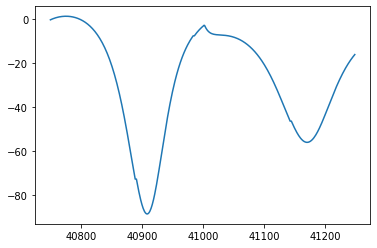

In [6]:
start_index = 35000
end_index = 45000
data_test = data[start_index:end_index]
# data_test = data
# data_test.plot(subplots=True, figsize=(16,15))


outlier_key = "f_c"
m = 500
preload_size = 5000
plt.plot(data[40750:41250][outlier_key])
outlier_model = OutlierModel(m=m,std_dev=2,
                             time_series=data_test[:preload_size][outlier_key],
                             egress=True,
                             lag=m,
                             influence=0.3,
                             threshold=3)


# Simulate stream of data
## Inverse transform test dataset for evaluation

In [7]:

# data_test = pd.DataFrame(models["scaler"].inverse_transform(data_test_scaled.drop(columns=cat_cols + [identifier,target])),
#                columns=data_test_scaled.drop(columns=cat_cols + [identifier,target]).columns.values)
# data_test[[identifier,target]] = data_test_scaled[[identifier,target]].copy()

In [8]:
data_test.head()

,f_c,P,m_d,m_q,theta,P_ref,V_DC,V_phaseA,V_phaseB,V_phaseC,I_phaseA,I_phaseB,I_phaseC,fault,sample_id
0,0.160401,102708.459241,311.0,0.0,-163.738242,2500.0,800.0,-259.299072,-19.057368,278.356440,294.335345,-928.391542,634.056197,0,0
1,0.267618,102492.887801,311.0,0.0,-163.738192,2500.0,800.0,-259.696384,-18.337809,278.034193,284.639238,-916.942492,632.303254,0,1
2,0.369417,102288.207648,311.0,0.0,-163.738108,2500.0,800.0,-260.114450,-17.577815,277.692264,274.799672,-905.428051,630.628379,0,2
3,0.465867,102094.284312,311.0,0.0,-163.737992,2500.0,800.0,-260.553771,-16.775993,277.329764,264.816484,-893.849302,629.032819,0,3
4,0.557028,101910.993770,311.0,0.0,-163.737845,2500.0,800.0,-261.014849,-15.930912,276.945761,254.689537,-882.207299,627.517762,0,4


* loading the whole DL model with preprocessors in each iteration is stupid but I wanted to send Alex at least some initial code

In [9]:
fault = False
for index, row in data_test[preload_size:].iterrows():
    if index % 10000 == 0:
        print(f"Current Global index: {index}")
    if not fault:
        outlier_model.train_one(row[outlier_key])
        outlier_model.predict_one(index)
        # print("fault start")
    else:
        # predicted = pipeline.predict(row, column_types_loc, save_loc)
        print("fault continues")
        # if predicted == 0:
        #     fault = False
        #     print("fault ended")

12/03/2021 09:28:33 PM:  Anomaly at Global index: 6239
12/03/2021 09:28:51 PM:  Anomaly at Global index: 15865
12/03/2021 09:29:07 PM:  Anomaly at Global index: 24918
12/03/2021 09:29:23 PM:  Anomaly at Global index: 33169
12/03/2021 09:29:24 PM:  Anomaly at Global index: 33951
12/03/2021 09:29:37 PM:  Anomaly at Global index: 41003
12/03/2021 09:29:53 PM:  Anomaly at Global index: 49477
12/03/2021 09:30:10 PM:  Anomaly at Global index: 58812
12/03/2021 09:30:15 PM:  Anomaly at Global index: 61160
12/03/2021 09:30:24 PM:  Anomaly at Global index: 66538
12/03/2021 09:30:28 PM:  Anomaly at Global index: 68491
12/03/2021 09:30:38 PM:  Anomaly at Global index: 73517
12/03/2021 09:30:42 PM:  Anomaly at Global index: 75629
12/03/2021 09:30:48 PM:  Anomaly at Global index: 78828
12/03/2021 09:30:50 PM:  Anomaly at Global index: 80001
12/03/2021 09:31:00 PM:  Anomaly at Global index: 85617
12/03/2021 09:31:02 PM:  Anomaly at Global index: 86583
12/03/2021 09:31:03 PM:  Anomaly at Global index:

Current Global index: 10000
Current Global index: 20000
Current Global index: 30000
Current Global index: 40000
Current Global index: 50000
Current Global index: 60000
Current Global index: 70000
Current Global index: 80000
Current Global index: 90000
Current Global index: 100000
Current Global index: 110000
Current Global index: 120000
Current Global index: 130000
Current Global index: 140000
Current Global index: 150000
Current Global index: 160000
Current Global index: 170000
Current Global index: 180000
Current Global index: 190000


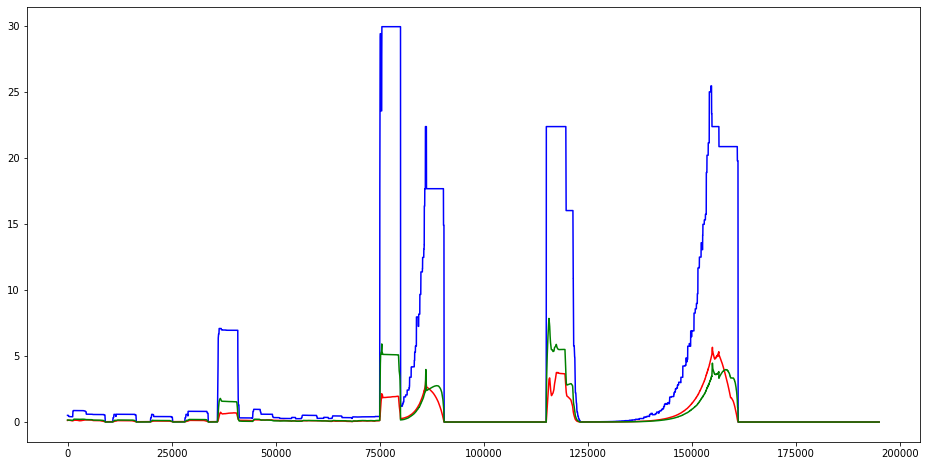

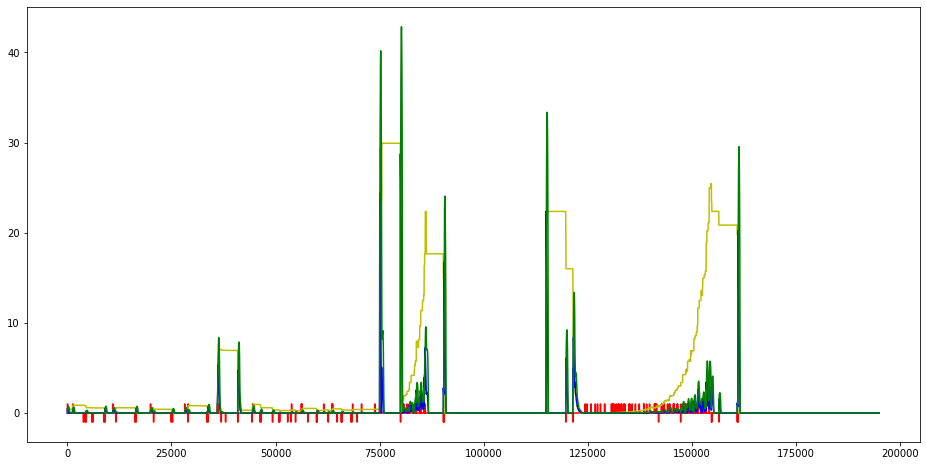

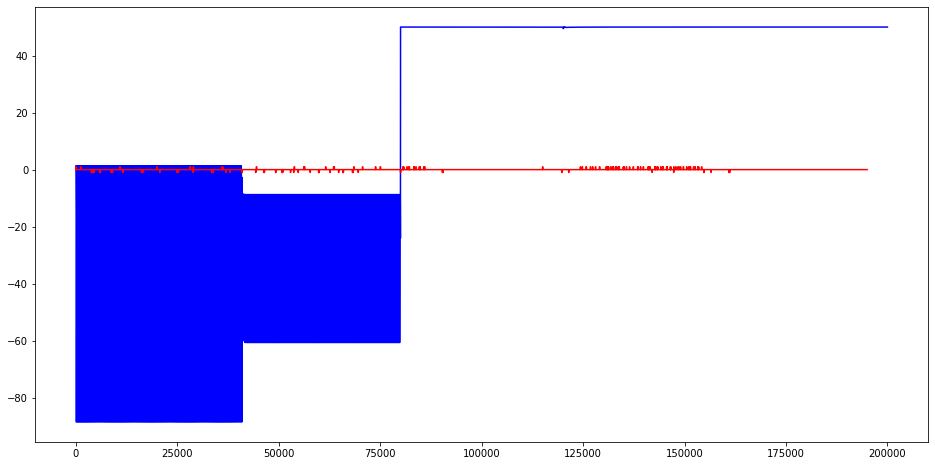

In [10]:
# plt.figure(figsize=(16,8))
# plt.plot(data[23500:27500][outlier_key])
plt.figure(figsize=(16,8))

plt.plot(outlier_model.max_val,'b-',
         outlier_model.max_mean,'r-',
         outlier_model.max_std_dev,'g-')
# plt.plot(outlier_model.max_std_dev)
plt.figure(figsize=(16,8))
plt.plot(outlier_model.comparisson, 'r-',
         outlier_model.max_val,'y-',
         outlier_model.avgFilter,'b-',
         outlier_model.stdFilter,'g-')

plt.figure(figsize=(16,8))
# plt.plot(data_test["fault"])
plt.plot(data_test[outlier_key], 'b-',outlier_model.comparisson, 'r-')

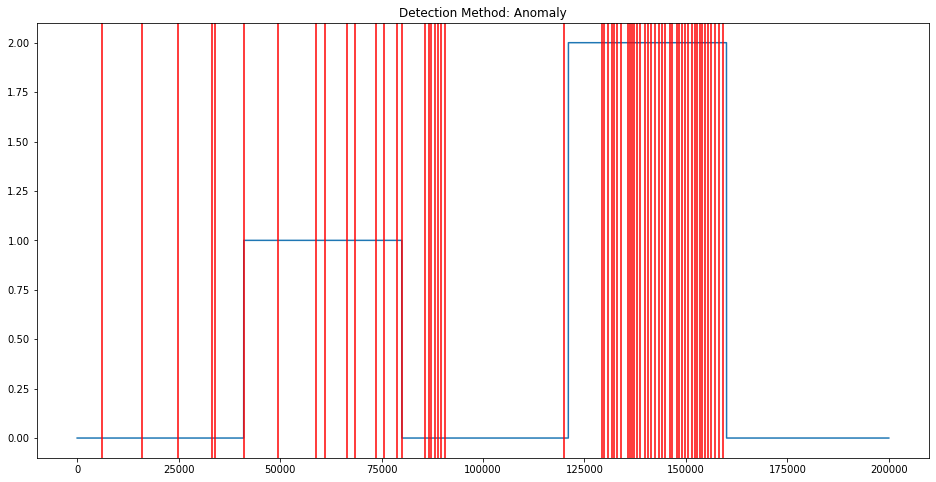

In [11]:
plt.figure(figsize=(16,8))
plt.plot(data_test["fault"])
plt.title(f"Detection Method: Anomaly")
for i in outlier_model.anomalies:
    plt.axvline(x=i,color='r')